# Inferential Modeling

In [1]:
#data manipulation and visualization libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scikitplot as skplt
import seaborn as sns
import pickle 
import os

#scaling module
from sklearn.preprocessing import StandardScaler

#model optimzation modules
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

#model modules
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


#metric modules
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, recall_score, accuracy_score 
from sklearn.metrics import precision_score, confusion_matrix, precision_recall_curve, fbeta_score, auc, plot_precision_recall_curve

## Model 1 - Inferential Model
The first model to build is a simple model that while lacking the performance of our churn filter, will be easily digested in order to explore which aspects of customer profiles are contributing to churn and thusly give departure points to analyze the business practices that might contribute to these numbers. 

### Model Selection

Two immediate models come to mind regarding simple/interpretable models for classification:
* Logistic Regression
    * When Data has a linear relationship.
    * Simplest form as the Coefficents produced directly relate to the rate of change of each feature has on the model's Decision.
* Decision Tree
    * When Data does not have a linear relationship.
    * Provides mapped out decision tree of how it came to decisions.
    
Addtionally to providing easily digestable results, these algorithms scale extremely well in performance and would be appropriate solutions to enterprise level of data.

In [2]:
#load data

df = pd.read_csv("simple_preprocessed_scaled_df.csv")
df.head()

#split data
X, y = df.iloc[:,:12], df.iloc[:,-1]

#train_test_split, 20% observations aside for testing, note will forgo validation split for this inferential exercise
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

In [3]:
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
0,-31.5288,1,0.110042,2,0.00,-0.5302,1,1,101348.88,1.0,0.0,0.0
1,-42.5288,1,0.085945,1,83807.86,-0.5302,0,1,112542.58,0.0,0.0,1.0
2,-148.5288,1,0.110042,8,159660.80,1.4698,1,0,113931.57,1.0,0.0,0.0
3,48.4712,1,0.035934,1,0.00,0.4698,0,0,93826.63,1.0,0.0,0.0
4,199.4712,1,0.133573,2,125510.82,-0.5302,1,1,79084.10,0.0,0.0,1.0


In [4]:
#data set is imbalanced (approx 20% of records are churrned) so I will calculate the class weights as an input to the LogisticRegression model
df_class_weights= compute_class_weight('balanced', classes=[0,1], y=y)
df_class_weights

array([0.62790406, 2.45459008])

For model optimziation, I will utlized ROC AUC as my lead scoring metric, as I want to optimize the model's ability to find the largest boundary between TPR/FPR.

Lets start by running a quick cross validation on both model types to see if there is any substantial difference.

In [5]:
#scaling data to optimize data for LogisiticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


log_reg_cv = cross_val_score(LogisticRegression(class_weight={0:0.62790406, 1:2.45459008}), X_train_scaled, y_train, cv=5, scoring='roc_auc')
dec_tree_cv = cross_val_score(DecisionTreeClassifier(class_weight={0:0.62790406, 1:2.45459008}), X_train, y_train, cv=5, scoring='roc_auc')

print('The Avg Area Under the ROC curve for Logistic Regression Classification averages: ' + str(round(np.mean(log_reg_cv),4)))
print('The Avg Area Under the ROC curve for Decision Tree Classification averages: ' + str(round(np.mean(dec_tree_cv),4)))

The Avg Area Under the ROC curve for Logistic Regression Classification averages: 0.7704
The Avg Area Under the ROC curve for Decision Tree Classification averages: 0.6861


The Cross Val showed promising given the constraints of these models type. Considering the scalability of each algorithm I'll optimize each to validate my findings.

In [6]:
#grid search for LogisticRegressor

l1_grid_params = {
                    'solver' : ['liblinear', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000]
}

l2_grid_params = {
                    'solver' : ['newton-cg', 'lbfgs','sag', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000]
}

en_grid_params = {
                    'solver' : ['newton-cg', 'lbfgs','sag', 'saga'],
                    'C' : [i for i in range(11)],
                    'max_iter' : [1000,5000,10000,50000],
                    'l1_ratio' : [.001, .01, .1, .25, .5, .75, .9, .99, .999]
}

log_params = [l1_grid_params, l2_grid_params, en_grid_params]
log_penalty = ['l1','l2', 'elasticnet']

for p_grid, log_penalty in zip(log_params, log_penalty):
    grid = GridSearchCV(LogisticRegression(random_state = 42, class_weight={0:0.62790406, 1:2.45459008}, penalty=log_penalty), p_grid,cv = 10, scoring='roc_auc', error_score=np.nan, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    
    print('Penalty: ' + str(log_penalty))
    print('Best Score: ' + str(grid.best_score_))
    print('Best Esitmator: ' +str(grid.best_estimator_) +'\n')

Penalty: l1
Best Score: 0.7707987017364756
Best Esitmator: LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   max_iter=1000, penalty='l1', random_state=42, solver='saga')

Penalty: l2
Best Score: 0.7707447679402105
Best Esitmator: LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   max_iter=1000, random_state=42, solver='sag')

Penalty: elasticnet
Best Score: 0.7707996648399803
Best Esitmator: LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.999, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')



GridSearch produced similiar results among different solvers and Regulraization stengths. Chose best performing ElasticNet solver to apply to data and analyze the effects the parameters have on the churn potential.

In [7]:
#build helper function to display results of model fit on test data

def results_pipe(model):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    print('Model Results')
    print('Accuracy: ' + str(accuracy_score(y_test, model.predict(X_test_scaled))))
    print('F1 ' + str(f1_score(y_test, model.predict(X_test_scaled))))
    print('ROC AUC :' + str(roc_auc_score(y_test, model.predict(X_test_scaled)))+'\n')
    print(classification_report(y_test,model.predict(X_test_scaled))+'\n')
    
    
    plt.figure(figsize=(40,12))
    grid = plt.GridSpec(1, 4, wspace=0.3, hspace=0.4)
    ax1 = plt.subplot(grid[0,0])
    confusion = confusion_matrix(y_test, y_pred)
    sns.heatmap(data=confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Stay', 'Exit'],
           yticklabels=['Stay', 'Exit'], ax=ax1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
    ax2 = plt.subplot(grid[0,1])    
    sns.lineplot(x=fpr[1], y=tpr[1],label='LogisticRegression', ax=ax2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver operating characteristic')
    sns.lineplot(x=[0,1],y=[0,1], label='Naive Classifier', ax=ax2)
    ax2.legend(loc='best')
    
    ax3 = plt.subplot(grid[0,2])
    plot_precision_recall_curve(model, X_test_scaled, y_test, ax=ax3);
    
    if str(model)[0] == 'L':
        zipped_cols_coefs = list(zip(X.columns,model.coef_[0]))
        coef_df = pd.DataFrame(zipped_cols_coefs,columns=['Feature','Coef'])
        coef_df.Coef = round(coef_df.Coef,4)
        coef_df.sort_values('Coef',ascending=False, key=abs)
        coef_df.set_index('Feature')
        coef_df = coef_df.sort_values('Coef', key=abs,ascending=False)
        ax4 = plt.subplot(grid[0,3])
        ax4 = sns.barplot(x=coef_df.Coef, y=coef_df.Feature,color='#4287f5')
        yabs_max = 1
        ax4.set_xlim(xmin=-yabs_max, xmax=yabs_max)
        ax4.set_title('Logistic Regression Coefficients')
    else:
        zipped_cols_fi = list(zip(X.columns,model.feature_importances_))
        fi_df = pd.DataFrame(zipped_cols_fi,columns=['Feature','Feature Importance'])
        fi_df['Feature Importance'] = round(fi_df['Feature Importance'],4)
        fi_df =fi_df.sort_values('Feature Importance',ascending=False, key=abs)
        ax4 = plt.subplot(grid[0,3])
        ax4 = sns.barplot(x=fi_df['Feature Importance'], y=fi_df.Feature, color='#4287f5')
        yabs_max = 1
        ax4.set_xlim(xmin=-yabs_max, xmax=yabs_max)
        ax4.set_title('Decision Tree Feature Importances')

Model Results
Accuracy: 0.709
F1 0.5034129692832764
ROC AUC :0.7148874606501725

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.39      0.72      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000




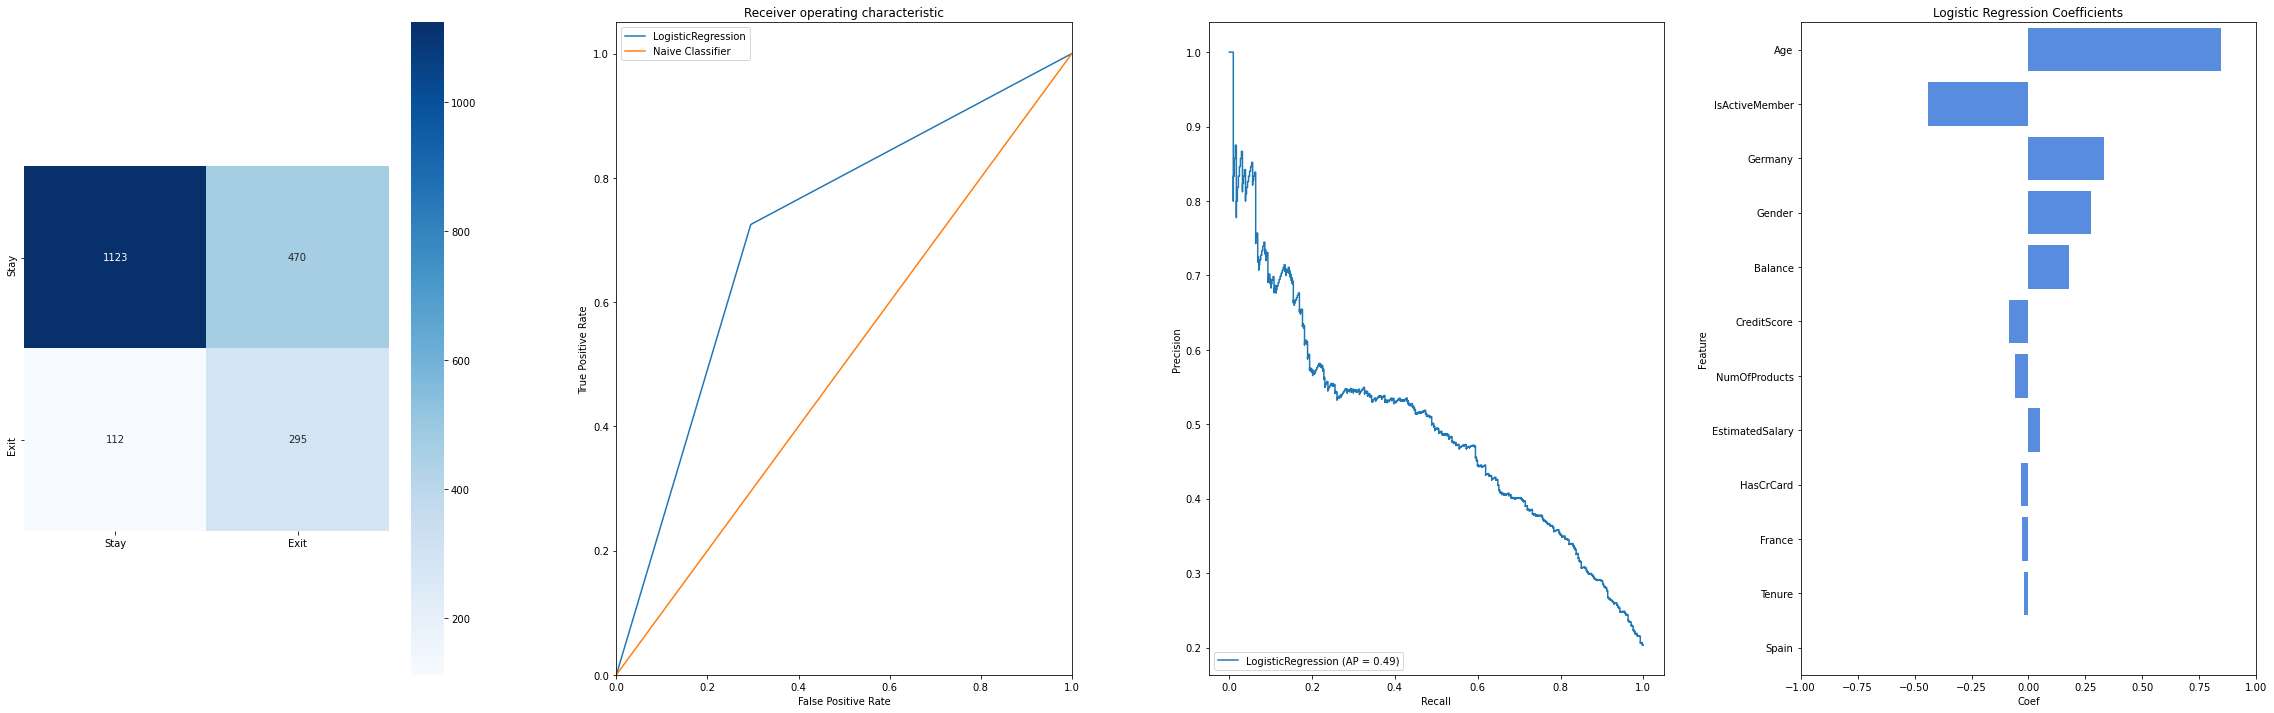

In [8]:
#print and graph the results of fitting LogisticRegression model on the data

results_pipe(LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.75, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga'))

#### LogisticRegression Results
The fit of the Regression model provided moderate results as the classifer was somewhat adept at capturing more than 2/3rds of the positive class with the correct label although a considerable amount of miss classfication within the negative class did occur. Considering the imbalance between the classes it is not surprising that the model was able to have greater success in identifying the negative class(non-Exited/current) as displayed by the classification report and F1-score.

In reiewing the model's Precision-Recall Curve, we can see that Precision for our Positive class maxes out around ~.85 so Type 1 Errors are an inevitable outcome of the model. Additionally we can observe that 

The model is showing considerable improvement over a baseline guessing estimate pltted along the ROC curve, so the findings should be insightful to which factors are contributing to the positive class.

Observing at the coefficents, (noting they are all scaled to reflect the parameter's z-score) Age provides the greatest affect on the model's score followed by the binary inputs of IsActiveMember, Germany and Gender.

Drawing your attention to the dataframe below, you can observe the baseline probability of the model chooseing the Positive (Exited) class in the non real world scenario of having all other units effect nullified (Scaled to 0/Parameter mean), along with each singular input's affect on the model when either activated as a binary input or adjusted by 1 Standard Deviation. As expected, Age holds the most considerable sway over the models adjustment in probability. Likely indicating that the Age input is a major contributor to customer base's churn.

In [9]:
lm = LogisticRegression(C=1, class_weight={0: 0.62790406, 1: 2.45459008},
                   l1_ratio=0.75, max_iter=5000, penalty='elasticnet',
                   random_state=42, solver='saga')


lm.fit(X_train_scaled, y_train)

effect_df = pd.DataFrame(columns=['Parameter', 'Parameter Probability', 'Delta From Baseline','Unit Change Represented'])
base_input = np.zeros((12,))
base_prob = lm.predict_proba(base_input.reshape(1,-1))[0][1]
effect_df = effect_df.append({'Parameter':'Baseline', 'Parameter Probability': round(base_prob,4), 'Delta From Baseline': '--' , 'Unit Change Represented' : '--'}, ignore_index=True)


for i in range(12):
    base_input = np.zeros((12,))
    base_input[i] = 1
    input_prob = lm.predict_proba(base_input.reshape(1,-1))[0][1]
    effect_df = effect_df.append({'Parameter':X.columns[i], 
                                  'Parameter Probability': round(input_prob,4), 
                                  'Delta From Baseline': round(input_prob-base_prob,4),
                                  'Unit Change Represented' : (lambda x : round(X.iloc[:,i].std(),2) if len(X.iloc[:,i].value_counts()) > 2 else 'Binary')(i)  }, ignore_index=True)


effect_df.at[3,'Unit Change Represented'] = 10.49
    
effect_df

,Parameter,Parameter Probability,Delta From Baseline,Unit Change Represented
0,Baseline,0.4204,--,--
1,CreditScore,0.3997,-0.0207,96.65
2,Gender,0.4880,0.0676,Binary
3,Age,0.6285,0.2081,10.49
4,Tenure,0.4160,-0.0045,2.89
5,Balance,0.4641,0.0437,62397.41
6,NumOfProducts,0.4064,-0.014,0.58
7,HasCrCard,0.4130,-0.0074,Binary
8,IsActiveMember,0.3185,-0.1019,Binary
9,EstimatedSalary,0.4328,0.0124,57510.49


In [10]:
# Pickle the model

dir_path = os.path.dirname(os.path.realpath('log_reg.pickle'))

with open(str(dir_path) + '/pickled_models/log_reg_model.pickle', 'wb') as to_write:
    pickle.dump(lm, to_write)

### DecisionTreeClassifer

For the next step in the inferential analysis we will turn our attention to the DecisionTree or CART model. This relatively simple form of the tree models seeks to "split" the data using decision points within the ranges of the input parameters. Decision for the splits are made based on how "pure" the resulting node or leaf would be, commonly measured in 'Gini' or 'Entropy'. 

As the goal of this exercise is to pull simple inference to build a case of cause of customer churn. Lets start by analysing how a simple a model we can create while maintaining performance.

In [11]:
df = pd.read_csv('simple_preprocessed_unscaled_df.csv')

#split data
X, y = df.iloc[:,:12], df.iloc[:,-1]

#train_test_split, 20% observations aside for testing, note will forgo validation split for this inferential exercise
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42, stratify=y)

In [12]:
size_grid = {'max_depth':[i for i in range(1,10)]}

f1_depth_grid  = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight={0:0.62790406, 1:2.45459008}), 
                     size_grid, cv = 10, scoring='f1',
                    error_score=np.nan, n_jobs=-1)

roc_depth_grid  = GridSearchCV(DecisionTreeClassifier(random_state=42,class_weight={0:0.62790406, 1:2.45459008}), 
                     size_grid, cv = 10, scoring='roc_auc',
                    error_score=np.nan, n_jobs=-1)

f1_depth_grid.fit(X, y)
roc_depth_grid.fit(X, y)



GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight={0: 0.62790406,
                                                            1: 2.45459008},
                                              random_state=42),
             n_jobs=-1, param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

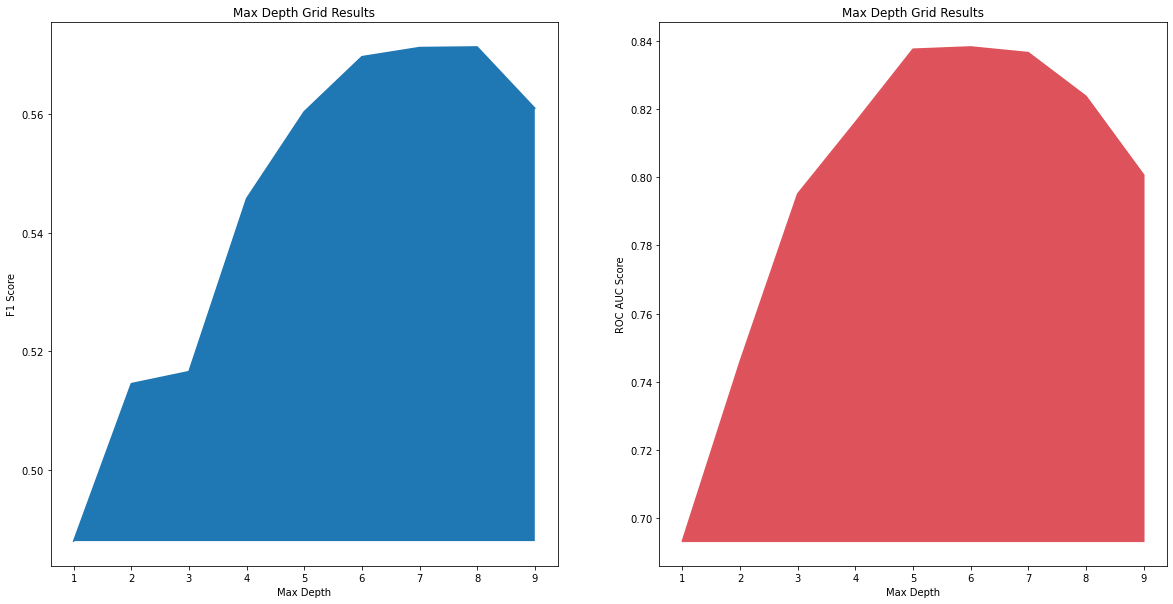

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax1, ax2 = axes

sns.lineplot(x=[i for i in range(1,10)], y= [i for i in f1_depth_grid.cv_results_['mean_test_score']], ax= ax1)
ax1.set_title('Max Depth Grid Results')
ax1.fill_between(x=[i for i in range(1,10)], y1=[i for i in f1_depth_grid.cv_results_['mean_test_score']], y2=min([i for i in f1_depth_grid.cv_results_['mean_test_score']]))
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('F1 Score')



sns.lineplot(x=[i for i in range(1,10)], y= [i for i in roc_depth_grid.cv_results_['mean_test_score']],color='#de525b', ax=ax2)
ax2.set_title('Max Depth Grid Results')
ax2.fill_between(x=[i for i in range(1,10)], y1=[i for i in roc_depth_grid.cv_results_['mean_test_score']], y2=min([i for i in roc_depth_grid.cv_results_['mean_test_score']]),color='#de525b')
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('ROC AUC Score');

As we increase depth, F1 Score and ROC AUC also increase. This is intuitive as the added layers allow for additional decision points to be made and greater order to be derived from the dataset. In continuing the theme of simiplicity I'll use a depth of 4.

In [14]:
As we increase depth, F1 Score and ROC AUC also increase. This is intuitive as the added layers allow for additional decision points to be made and greater order to be derived from the dataset. In continuing the theme of simiplicity I'll use a depth of 4.

In [79]:
#gridsearch the contstraints of the DecisonTree algroithm, note the decision to limit depth in order to keep a relatively simple decision structure

grid_params = {
               'min_samples_leaf' : [i for i in range(1,100)] ,
               'min_samples_split' : [i for i in range(115,136)]}


grid = GridSearchCV(DecisionTreeClassifier(random_state = 42,
                            class_weight={0:0.62790406, 1:2.45459008}, max_depth=4, criterion='entropy'), grid_params, cv=5, scoring='roc_auc', error_score=np.nan, n_jobs=-1)

grid.fit(X, y)

print('Best Score: ' + str(grid.best_score_))
print('Best Esitmator: ' +str(grid.best_estimator_))

Best Score: 0.8168931915549162
Best Esitmator: DecisionTreeClassifier(class_weight={0: 0.62790406, 1: 2.45459008},
                       criterion='entropy', max_depth=4, min_samples_leaf=50,
                       min_samples_split=115, random_state=42)


Model Results
Accuracy: 0.7695
F1 0.5605338417540514
ROC AUC :0.7519514892396248

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.46      0.72      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.77      0.79      2000




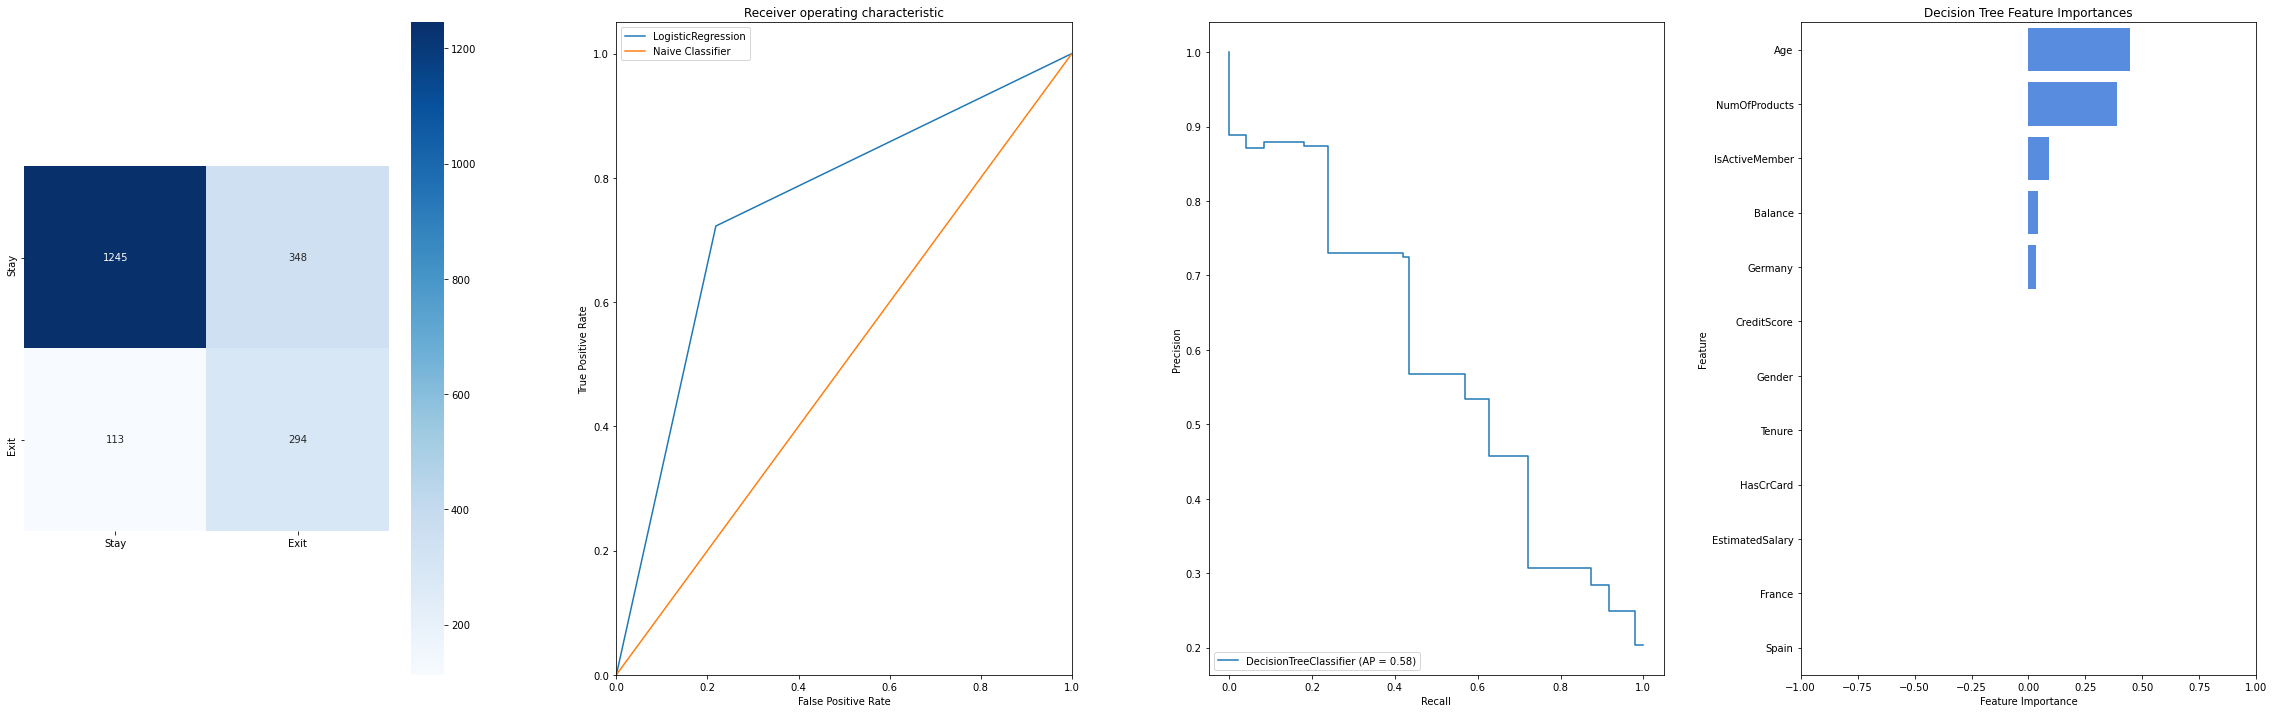

In [15]:
results_pipe(DecisionTreeClassifier(class_weight={0: 0.62790406, 1: 2.45459008},
                       criterion='entropy', max_depth=4, min_samples_leaf=50,
                       min_samples_split=115, random_state=42))

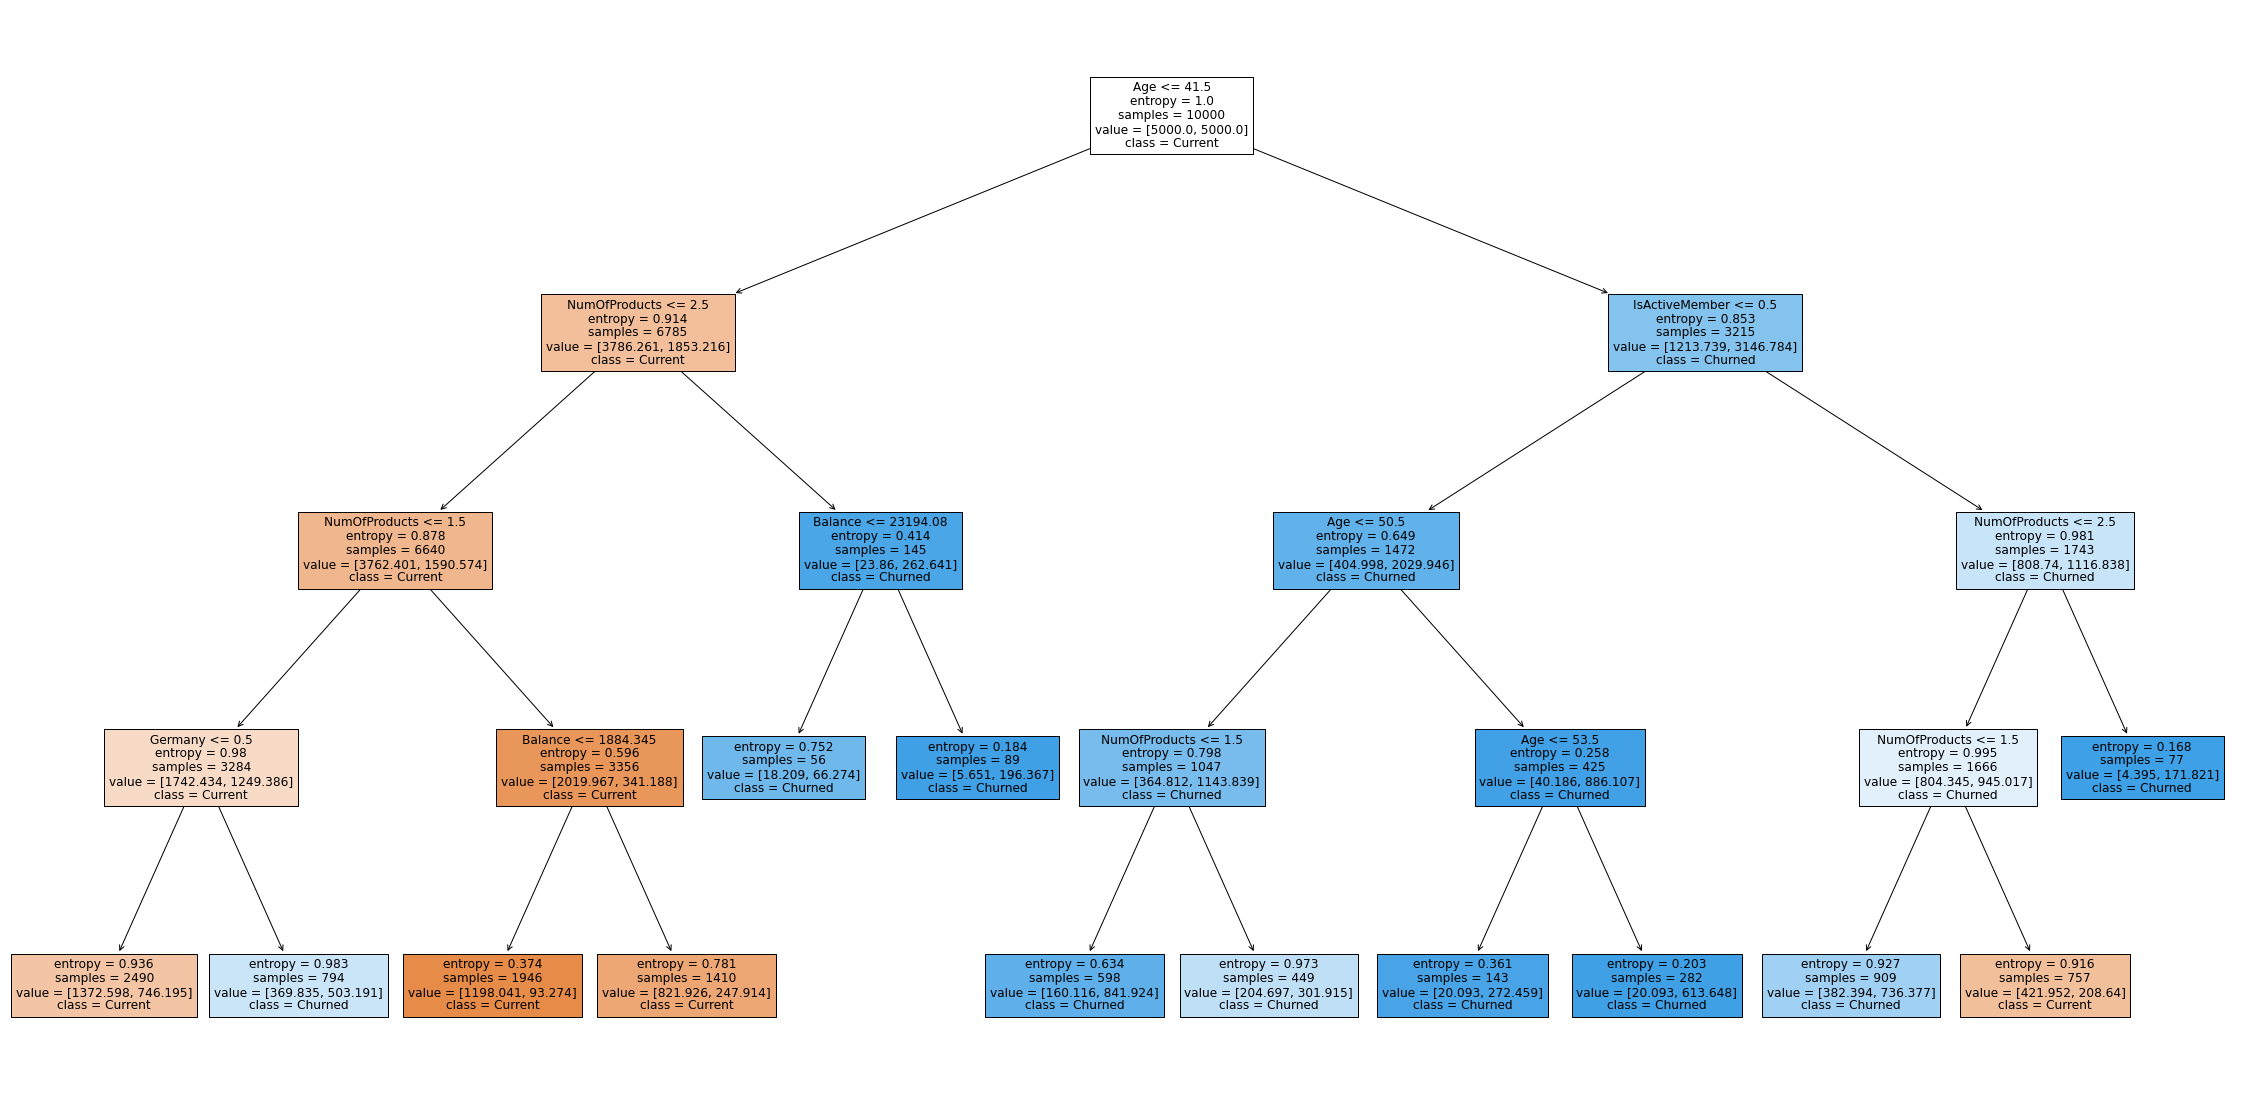

In [16]:
dt = DecisionTreeClassifier(class_weight={0: 0.62790406, 1: 2.45459008},
                       criterion='entropy', max_depth=4, min_samples_leaf=50,
                       min_samples_split=115, random_state=42)
dt.fit(X, y)

fig = plt.figure(figsize=(40,20))
_ = plot_tree(dt, 
                   feature_names=X.columns,  
                   class_names=['Current', 'Churned'],
                   filled=True)

In [17]:
# Pickle the model

dir_path = os.path.dirname(os.path.realpath('dec_tree.pickle'))

with open(str(dir_path) + 'dec_tree.pickle', 'wb') as to_write:
    pickle.dump(dt, to_write)

#### Decision Tree Results
Switching to a tree model provided a small gain in model performance. Minor improvements in Accuracy, Precision, Recall and F1 were experienced, as utilizng the Decision Tree solution of choosing parameters that can provided the greatest reduction in Entropy were the better fit for the data provided.

The .5 threshold garners a .56 F1 score between .46 Precision and .72 Recall. So of the observations the model classifies as being 'Exited' it is correct 46% of the time. And of the tested observations, those that actually 'Exited' are classified so 72% of the time. In observing the precision-recall curse, we can see how adjustments of the decision threshold can affect the interplay between Precision-Recall and thusly F1.

In observing the decision tree that was generated from the model, we see Age (<=41.5) as the first parameter in which the model gained the most information. Followed by the Number of Products (<=2.5) and their Actiivty status. Looking at the feature importances produced, we see Age and Number of Products were the most powerful decision parameters (were weighted the highest from the full tree).

## Takeaways

##### Main Takeaway
*Age* - From this exercise in Inferential modeling, we see strong indicated that Age the primary indicator of churn among the Bank's customers. The relationship is positively correlated, so as customers get older they become more and more likely to leave the Bank (10 years resulted in 20% increase in churn according to LogisticRegressor). This could be due to Products or Services not meeting the investment needs at the clientel are reaching middle age. There could be interest in funds or investment opporunities for this children that are not met by the bank.

<br />

###### Needle Movers
*Is Active Member* - Found in both models, the binary input of having account transaction activity shows to support Customer longevity. This metric can be seen as proxy for engagement, proving that even passive services such as banking still can improve their stickyness. This proves true in that engagement allows for customers to experience the product/service's value proposition and potentnially convert to higher levels service loyalty.

*Germany* - Modeling data along with EDA showed higher rates of churn among German customers. This was surprising as my pursumption is that EU banking laws would incentive international investment whenever possible. Lets look into this further:

In [17]:
# Pickle the model

with open('dec_tree.pickle', 'wb') as to_write:
    pickle.dump(dt, to_write)

#### Decision Tree Results
Switching to a tree model provided a small gain in model performance. Minor improvements in Accuracy, Precision, Recall and F1 were experienced, as utilizng the Decision Tree solution of choosing parameters that can provided the greatest reduction in Entropy were the better fit for the data provided.

The .5 threshold garners a .56 F1 score between .46 Precision and .72 Recall. So of the observations the model classifies as being 'Exited' it is correct 46% of the time. And of the tested observations, those that actually 'Exited' are classified so 72% of the time. In observing the precision-recall curse, we can see how adjustments of the decision threshold can affect the interplay between Precision-Recall and thusly F1.

In observing the decision tree that was generated from the model, we see Age (<=41.5) as the first parameter in which the model gained the most information. Followed by the Number of Products (<=2.5) and their Actiivty status. Looking at the feature importances produced, we see Age and Number of Products were the most powerful decision parameters (were weighted the highest from the full tree).

## Takeaways

##### Main Takeaway
*Age* - From this exercise in Inferential modeling, we see strong indicated that Age the primary indicator of churn among the Bank's customers. The relationship is positively correlated, so as customers get older they become more and more likely to leave the Bank (10 years resulted in 20% increase in churn according to LogisticRegressor). This could be due to Products or Services not meeting the investment needs at the clientel are reaching middle age. There could be interest in funds or investment opporunities for this children that are not met by the bank.

<br />

###### Needle Movers
*Is Active Member* - Found in both models, the binary input of having account transaction activity shows to support Customer longevity. This metric can be seen as proxy for engagement, proving that even passive services such as banking still can improve their stickyness. This proves true in that engagement allows for customers to experience the product/service's value proposition and potentnially convert to higher levels service loyalty.

*Germany* - Modeling data along with EDA showed higher rates of churn among German customers. This was surprising as my pursumption is that EU banking laws would incentive international investment whenever possible. Lets look into this further:

In [18]:
df.groupby(['Exited','Germany','France','Spain']).mean()

CreditScore    Gender        Age    Tenure  \
Exited Germany France Spain                                               
0      0.0     0.0    1.0     652.104167  0.415698  37.839147  5.107558   
               1.0    0.0     651.162226  0.428402  37.235966  5.005471   
       1.0     0.0    0.0     653.261357  0.439528  37.311504  5.011799   
1      0.0     0.0    1.0     647.484262  0.559322  44.147700  4.656174   
               1.0    0.0     641.914815  0.567901  45.133333  5.000000   
       1.0     0.0    0.0     647.689189  0.550369  44.894349  5.006143   

                                   Balance  NumOfProducts  HasCrCard  \
Exited Germany France Spain                                            
0      0.0     0.0    1.0     59678.070470       1.544574   0.699128   
               1.0    0.0     60339.275678       1.541389   0.707422   
       1.0     0.0    0.0    119427.106696       1.551032   0.716224   
1      0.0     0.0    1.0     72513.352446       1.513317   0.673123   
               1.0    0.0     71192.795728       1.476543   0.702469   
       1.0     0.0    0.0    120361.075590       1.454545   0.708845   

                             IsActiveMember  EstimatedSalary  
Exited Germany France Spain                                   
0      0.0     0.0    1.0          0.567345     98602.369864  
               1.0    0.0          0.545433     99217.097331  
       1.0     0.0    0.0          0.561652    102414.657876  
1      0.0     0.0    1.0          0.341404    103629.554818  
               1.0    0.0          0.367901    103439.278296  
       1.0     0.0    0.0          0.363636     98403.886450

Looking accross the three countries, the only variable that stands out is Germany's Balance. The magnitude of which is likely due to lack of 0 balances then higher average balances for each member. Let's confirm:

In [19]:
df['BalanceZero'] = df.Balance.apply(lambda x: 1 if x == 0 else 0)
df.groupby(['Exited','Germany','France','Spain'])['BalanceZero'].sum()

Exited  Germany  France  Spain
0       0.0      0.0     1.0      1036
                 1.0     0.0      2081
        1.0      0.0     0.0         0
1       0.0      0.0     1.0       163
                 1.0     0.0       337
        1.0      0.0     0.0         0
Name: BalanceZero, dtype: int64

And indeed all German observation have a non-zero balance associated with them. This pattern would be indicative to a sevice mandate requiring a balance of X amount held within a customer account at all times (min Balance value of German customers is 27288.43&euro;) This requirement while likely being a barrier to entry for the service also proves to be pushing customers out at higher rate then their Spanish and French peers.

Next Step: 4/4 Prediction Modeling